# Wavelet Attribution Method (WAM) - Demo notebook

This notebook shows how to use the Wavelet Attribution Method (WAM) to visualize what scales matter most to a model's predictions. For the full technical details, check out [our paper](https://openreview.net/forum?id=njZ5oVPObS) or the [project repository](https://github.com/gabrielkasmi/wam)

In [ ]:
# Clone the WAM repository
!git clone https://github.com/gabrielkasmi/wam.git
%cd wam

# Install required packages from requirements.txt
!pip install -r requirements.txt

In [5]:
# Libraries imports
from torchvision import transforms, models
import torch
from lib.wam_2D import WaveletAttribution2D
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.viewers import plot_wam

In [6]:
# Set up the model and the explainer

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# parameters for the explainer
wavelet="haar"
levels=3
method="smooth" # choose between "integratedgrad" or "smooth"
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

explainer = WaveletAttribution2D(model,
                                 wavelet=wavelet,
                                 J=levels,
                                 method=method,
                                 mode="reflect",
                                 )

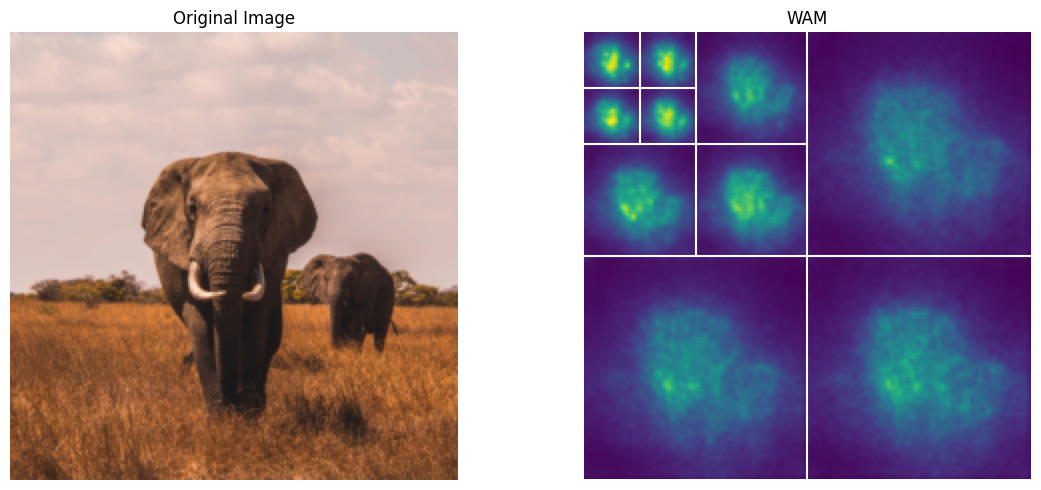

In [8]:
# load the image
x=transform(Image.open("assets/elephant.jpg")).unsqueeze(0)
y=model(x.to(device)).argmax().item()

# compute the explanations
explantions=explainer(x,y)

# display the results
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot original image on the left
# Convert tensor back to image format and denormalize
img = x.squeeze(0).permute(1,2,0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)
ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')

# Plot WAM on the right using the provided plot_wam function
plot_wam(ax2, explantions[0], levels=levels, cmap='viridis', smooth=True)
ax2.set_title('WAM')
ax2.axis('off')

plt.tight_layout()
plt.show()
